# Explore the terrain classification data

This workbook contains an exploration of the classification data that was created by multiple users using the classifcation application deployed on AWS.

This workbook assumes that the Combine_Seperate_Classification_Files workbook has been run, and that the resulting pickle file (all_data.pkl) as created by that workbook is in the "classified" sibling folder

In [227]:
import pandas as pd

classified_data = pd.read_pickle('../../classified/all_data.pkl')
# Remove 12 null rows - an artifact of the classification app
classified_data = classified_data[~classified_data['xCoord'].isnull()]

In [127]:
video_info = pd.read_csv('../Video_Info.csv')

classified_data['videoId'] = classified_data['sourceImageName'].str[:8]

classified_data = pd.merge(classified_data, video_info, how='left', left_on='videoId', 
                           right_on='File_ID').drop(['Video_File', 'File_ID'], axis=1)

,sourceImageName,classificationSourceQueue,classifiedOn,xCoord,yCoord,category,videoId,Date,Time,Time_From_Daylight_Start,Time_To_Daylight_End,Conditions
0,DJI_00991600,user1,"5/30/2020, 5:12:22 PM",127.0,71.0,foliage,DJI_0099,03/05/2020,11:40,5.77,9.40,Partly_Cloudy
1,DJI_00991600,user1,"5/30/2020, 5:12:22 PM",127.0,70.0,foliage,DJI_0099,03/05/2020,11:40,5.77,9.40,Partly_Cloudy
2,DJI_00991600,user1,"5/30/2020, 5:12:22 PM",127.0,69.0,foliage,DJI_0099,03/05/2020,11:40,5.77,9.40,Partly_Cloudy
3,DJI_00991600,user1,"5/30/2020, 5:12:22 PM",127.0,68.0,foliage,DJI_0099,03/05/2020,11:40,5.77,9.40,Partly_Cloudy
4,DJI_00991600,user1,"5/30/2020, 5:12:22 PM",127.0,67.0,foliage,DJI_0099,03/05/2020,11:40,5.77,9.40,Partly_Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
9086075,DJI_01301300,user3,"6/2/2020, 9:12:51 AM",0.0,4.0,water,DJI_0130,01/06/2020,19:26,14.23,2.37,Sunny
9086076,DJI_01301300,user3,"6/2/2020, 9:12:51 AM",0.0,3.0,water,DJI_0130,01/06/2020,19:26,14.23,2.37,Sunny
9086077,DJI_01301300,user3,"6/2/2020, 9:12:51 AM",0.0,2.0,water,DJI_0130,01/06/2020,19:26,14.23,2.37,Sunny
9086078,DJI_01301300,user3,"6/2/2020, 9:12:51 AM",0.0,1.0,water,DJI_0130,01/06/2020,19:26,14.23,2.37,Sunny


In [207]:
classification_count = classified_data.groupby('category').agg(['count']).reset_index()
classification_count.columns = classification_count.columns.get_level_values(0)

category_count = pd.DataFrame({'Category' : classification_count.category,
              'Count' : classification_count.sourceImageName})

,Category,Count
0,building,56661
1,foliage,7961958
2,road,249040
3,water,818421


## Evaluate the percentage of categories in the source images

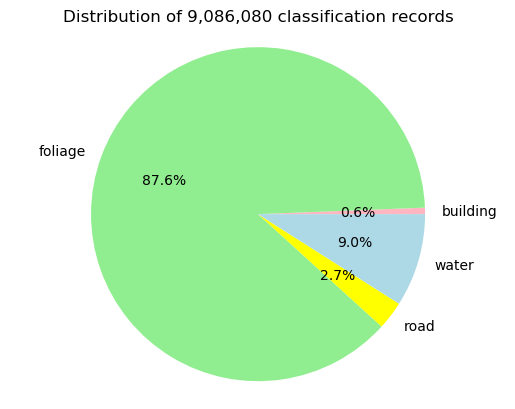

In [218]:
import matplotlib.pyplot as plt
plt.rcdefaults()

fig1, ax1 = plt.subplots()
ax1.pie(category_count.Count, labels=category_count.Category, autopct='%1.1f%%',
        colors=['lightpink', 'lightgreen', 'yellow', 'lightblue'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of {:,} classification records'.format(len(classified_data)))

plt.show()

## Compare images classified by multiple users

Some images were classified by more than one user, to allow for validation in order to analyze how closely two seperate people classify the same image. Firstly, find those images and their classification data

In [128]:
# Find images that have been classified multiple times
images_per_queue = classified_data[['sourceImageName', 
                                    'classificationSourceQueue']].drop_duplicates()
images_per_queue['noClassifications'] = images_per_queue.groupby('sourceImageName')[
                                            'classificationSourceQueue'].transform('count')
multiple_classification_images = images_per_queue[images_per_queue.groupby('sourceImageName')[
                                            'classificationSourceQueue'].transform('count') > 1]
multiple_classification_images = multiple_classification_images[['sourceImageName', 
                                                                 'noClassifications']].drop_duplicates()

# Now retrieve the classification for the list of images 
multiple_classifications = pd.merge(multiple_classification_images, classified_data, how='left', 
                                    left_on='sourceImageName', right_on='sourceImageName')
multiple_classifications = multiple_classifications.drop(['classifiedOn', 'videoId', 
                                                          'Date', 'Time', 'Time_From_Daylight_Start', 
                                                          'Time_To_Daylight_End', 'Conditions'], axis=1)

# Some images have duplicated classification information. Remove that
multiple_classifications = multiple_classifications.drop_duplicates()
multiple_classifications

,sourceImageName,noClassifications,classificationSourceQueue,xCoord,yCoord,category
0,DJI_01252600,2,user1,127.0,71.0,foliage
1,DJI_01252600,2,user1,127.0,70.0,foliage
2,DJI_01252600,2,user1,127.0,69.0,foliage
3,DJI_01252600,2,user1,127.0,68.0,foliage
4,DJI_01252600,2,user1,127.0,67.0,foliage
...,...,...,...,...,...,...
755707,DJI_0123900,2,user3,0.0,4.0,foliage
755708,DJI_0123900,2,user3,0.0,3.0,foliage
755709,DJI_0123900,2,user3,0.0,2.0,foliage
755710,DJI_0123900,2,user3,0.0,1.0,foliage


## Compare classified values from multiple users

Inspecting the data shows that all images that were multiply classified were classified twice. Therefore we can construct a dataset with the first classifaction in a left column, and the second classification on the right

In [129]:
first_queue = multiple_classifications.groupby('sourceImageName').first()
first_queue = first_queue.reset_index()

first_queue = first_queue.drop(['noClassifications', 'xCoord', 'yCoord', 'category'], axis = 1)

first_classification = pd.merge(first_queue,  multiple_classifications, how='left', 
                                left_on=['sourceImageName', 'classificationSourceQueue'], 
                                right_on=['sourceImageName', 'classificationSourceQueue'])
first_classification

,sourceImageName,classificationSourceQueue,noClassifications,xCoord,yCoord,category
0,DJI_01190,user2,2,127.0,71.0,foliage
1,DJI_01190,user2,2,127.0,70.0,foliage
2,DJI_01190,user2,2,127.0,69.0,foliage
3,DJI_01190,user2,2,127.0,68.0,foliage
4,DJI_01190,user2,2,127.0,67.0,foliage
...,...,...,...,...,...,...
350203,DJI_01345000,user1,2,0.0,4.0,foliage
350204,DJI_01345000,user1,2,0.0,3.0,foliage
350205,DJI_01345000,user1,2,0.0,2.0,foliage
350206,DJI_01345000,user1,2,0.0,1.0,foliage


In [130]:
find_non_connected = pd.merge(multiple_classifications, first_classification, how='outer', 
                              suffixes=('','_y'), indicator=True, left_on = ['sourceImageName', 
                                                                             'classificationSourceQueue', 
                                                                             'xCoord', 'yCoord'],
                              right_on = ['sourceImageName', 'classificationSourceQueue', 
                                          'xCoord', 'yCoord'])

second_classification = find_non_connected[find_non_connected['_merge']=='left_only'][multiple_classifications.columns]

merged_data = pd.merge(first_classification, second_classification, how='outer', 
                       suffixes=('_1','_2'), indicator = True, 
                       left_on = ['sourceImageName', 'xCoord', 'yCoord'], 
                       right_on = ['sourceImageName', 'xCoord', 'yCoord'])

def bool_to_int(x):
    return 1 if x else 0

merged_data['match'] = [bool_to_int(val) for val in (merged_data['category_1'] == merged_data['category_2'])]


### Check 1: Compare overall match

In [163]:
total_observations = len(merged_data)
matched_classifications = merged_data['match'].sum()

print('{} matched from {}'.format(matched_classifications, total_observations))
print('{0:.0%} matched'.format(matched_classifications / total_observations))

346461 matched from 350208
99% matched


### Check 2: Compare match per category

In [164]:
category_grouped = merged_data.groupby('category_1')['match'].agg(['sum','count'])
category_grouped = category_grouped.reset_index()
category_grouped['percentage_match'] = category_grouped['sum'] / 
                                        category_grouped['count'] * 100
category_grouped

,category_1,sum,count,percentage_match
0,building,744,922,80.694143
1,foliage,310083,311856,99.431468
2,road,2258,2813,80.270174
3,water,33376,34617,96.415056
